In [29]:
from cpppo.server.enip import client
from cpppo.server.enip.get_attribute import attribute_operations
import time
import matplotlib.pyplot as plt
import numpy as np

# for polling functionality
import logging
import sys
import time
import threading

import cpppo
from cpppo.server.enip import poll
from cpppo.server.enip.get_attribute import proxy_simple as device

In [30]:
class DL100:
    def __init__(self):
        self.ip_address = "192.168.100.236"
        # class code for position sensor object
        self.tag_position_sensor = ["@0x23/1/10"]
        # variable holds the latest measurement.
        self.position = 0
        # time taken for getting the measurement in millisec.
        self.meas_duration = 0
        self.depth = 25
        self.operations = attribute_operations(self.tag_position_sensor, route_path=[], send_path='' )
    
    def get_position_data_sync(self):
        start_time = time.time()
        with client.connector(host=self.ip_address) as conn:
            for index, descr, op, reply, status, value in conn.synchronous(operations=self.operations):
                self.position = self._convert_meas_data(value)
        self.meas_duration = 1000*(time.time() - start_time)
        return self.position
    
    def get_position_data_pipe(self):
        start_time = time.time()
        with client.connector(host=self.ip_address) as conn:
            for index, descr, op, reply, status, value in conn.pipeline(operations=self.operations, depth=self.depth):
                self.position = self._convert_meas_data(value)
        self.meas_duration = 1000*(time.time() - start_time)
        return self.position
    
    def get_position_data_polling(self):
        """
        once start() is called, data tuple starts appending to dict values.
        eg: at any time, values array would look like:
                {('@1/1/1', 'INT'): [808],
                 ('@1/1/7', 'SSTRING'): ['DL100'],
                 ('@0x23/1/10', 'DINT'): [4510]}
         with every popitem() call on values, latest (last appended) value popped out
        """
        values = {} # { <parameter>: (<timer>, <value>), ... }
        poller = threading.Thread(
            target=poll.poll, kwargs={ 
                'proxy_class': device,
                'address': ("192.168.100.236", 44818), # 44818: port for Ethernet IP
                'cycle': 1.0,
                'timeout': 0.5,
                'process': lambda par,val: values.update( { par: val } ),
                'params': [('@1/1/1','INT'),('@0x23/1/10','DINT')],
            })
#         poller.daemon = True
        poller.start()
#         poller.join()
        print(f'values: {values}')
        # Monitor the values dict (updated in another Thread)
        while True:
            while values:
                # sample output of popitem: ('@0x23/1/10', 'DINT'): [4131]
                popped_out = values.popitem()
                # attribute id matches with distance.
                if (popped_out[0] == ('@0x23/1/10', 'DINT')):
                    curr_distance = popped_out[1]
                    print(f'curr_distance: {curr_distance}')
#                 logging.warning( "%16s == %r", *values.popitem() )
#             print('values array empty')
#             time.sleep( .001 )
        
        
    
    def _convert_meas_data(self, meas_data):
        """
        data read from scanner in changed endian. Use the function to convert raw data to position value.
        Data recorded in mm
        """
        distance_calc = meas_data[0] + meas_data[1]*(16**2) + meas_data[2]*(16**4) + meas_data[3]*(16**6)
        return distance_calc
    
    def get_measurement_duration(self):
        return self.meas_duration

In [31]:
dl100_current = DL100()
posn_current = dl100_current.get_position_data_sync()
meas_duration = dl100_current.get_measurement_duration()
print(f'posn_current:{posn_current}, meas_duration: {meas_duration}')

posn_current:4573, meas_duration: 26.5960693359375


In [32]:
# values_dict = {}
dl100_current.get_position_data_polling()

values: {}
curr_distance: [4573]
curr_distance: [4573]
curr_distance: [4574]
curr_distance: [4573]
curr_distance: [4574]
curr_distance: [4573]
curr_distance: [4574]
curr_distance: [4573]
curr_distance: [4573]
curr_distance: [4573]
curr_distance: [4573]
curr_distance: [4573]
curr_distance: [4573]
curr_distance: [4572]
curr_distance: [4833]
curr_distance: [4869]
curr_distance: [4682]
curr_distance: [4714]
curr_distance: [4692]
curr_distance: [4764]
curr_distance: [4746]
curr_distance: [4735]
curr_distance: [4799]
curr_distance: [4801]
curr_distance: [4801]


KeyboardInterrupt: 

In [53]:
# Monitor the values dict (updated in another Thread)

while True:
    while values_dict:
        # sample output of popitem: ('@0x23/1/10', 'DINT'): [4131]
        popped_out = values_dict.popitem()
        # attribute id matches with distance.
        if (popped_out[0] == ('@0x23/1/10', 'DINT')):
            curr_distance = popped_out[1]
            print(f'curr_distance: {curr_distance}')
    time.sleep( .1 )

KeyboardInterrupt: 

In [141]:
# test to check the run time for consecutive measurements
measurements_position_sync = []
measurements_duration_sync = []
trials = 500
dl100_current = DL100()
for i in range(trials):
    posn_current = dl100_current.get_position_data_sync()
    meas_duration = dl100_current.get_measurement_duration()
    measurements_position_sync.append(posn_current)
    measurements_duration_sync.append(meas_duration)

ConnectionRefusedError: [Errno 61] Connection refused

sync average: 49.82125902175903, sync max: 1049.2660999298096, sync min: 17.663955688476562


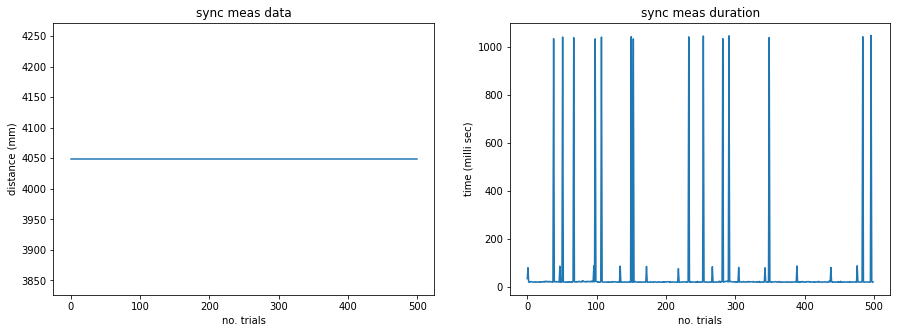

In [40]:
# plotting the results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax1.plot(measurements_position_sync)
ax1.set_title('sync meas data')
ax1.set_xlabel('no. trials')
ax1.set_ylabel('distance (mm)')

ax2.plot(measurements_duration_sync)
ax2.set_title('sync meas duration')
ax2.set_xlabel('no. trials')
ax2.set_ylabel('time (milli sec)')

print(f'sync average: {np.mean(measurements_duration_sync)}, sync max: {np.max(measurements_duration_sync)}, sync min: {np.min(measurements_duration_sync)}')

In [41]:
# test to check the run time for consecutive measurements
measurements_position_pip = []
measurements_duration_pip = []
trials = 500
dl100_current = DL100()
for i in range(trials):
    posn_current = dl100_current.get_position_data_pipe()
    meas_duration = dl100_current.get_measurement_duration()
    measurements_position_pip.append(posn_current)
    measurements_duration_pip.append(meas_duration)

sync average: 43.65539312362671, sync max: 1101.4699935913086, sync min: 18.013954162597656


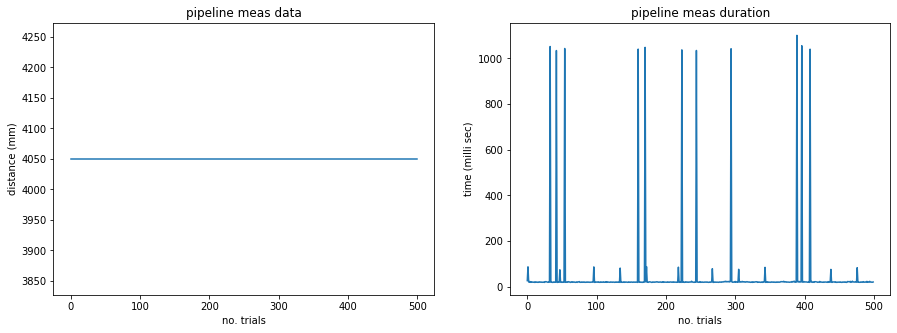

In [42]:
# plotting the results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax1.plot(measurements_position_pip)
ax1.set_title('pipeline meas data')
ax1.set_xlabel('no. trials')
ax1.set_ylabel('distance (mm)')

ax2.plot(measurements_duration_pip)
ax2.set_title('pipeline meas duration')
ax2.set_xlabel('no. trials')
ax2.set_ylabel('time (milli sec)')
print(f'pipe average: {np.mean(measurements_duration_pip)}, sync max: {np.max(measurements_duration_pip)}, sync min: {np.min(measurements_duration_pip)}')